# Project 4b - Image Warping and Mosaicing

### Dependencies

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from harris import get_harris_corners, dist2

## Interest Point Detector

In [15]:
# Load images and points
image1 = plt.imread('../data/IMG_8405.jpeg')
image2 = plt.imread('../data/IMG_8406.jpeg')

# make panoramal left b&w
image1_gray = np.mean(image1, axis=2)
image2_gray = np.mean(image2, axis=2)

h1, corners1 = get_harris_corners(image1_gray)
h2, corners2 = get_harris_corners(image2_gray)

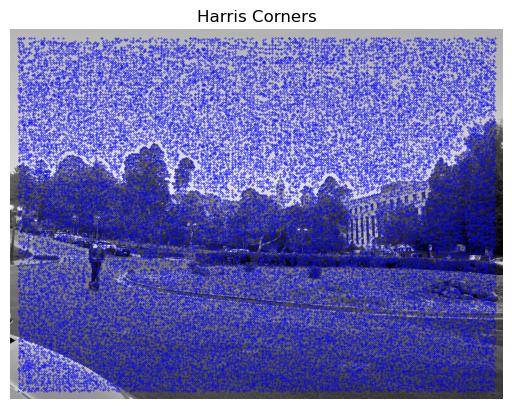

In [12]:
# Display the image
plt.imshow(image1_gray, cmap='gray')
plt.scatter(corners1[1], corners1[0], c='b', s=0.1)  # coords[1] for x, coords[0] for y
plt.title('Harris Corners')
plt.axis('off')
plt.show()

## Adaptive Non-Maximal Suppression

In [4]:
def adaptive_non_maximal_suppression(corners, h, num_points=500, c_robust=0.9):
    """
    Adaptive Non-Maximal Suppression following the approach outlined.
    
    :param corners: (2, n) array of corner coordinates (ys, xs).
    :param h: Harris response values of the image.
    :param num_points: Number of points to retain after ANMS.
    :param c_robust: Constant used in suppression condition (default = 0.9).
    :return: Array of suppressed corner coordinates.
    """
    # Extract Harris strengths for each corner point
    scores = h[corners[0], corners[1]]
    
    # Calculate pairwise distances between all corners using dist2()
    dists = dist2(corners.T, corners.T)  # corners.T is of shape (n, 2)
    
    # Broadcast comparison: f(x_i) < c_robust * f(x_j)
    larger_mask = scores[:, np.newaxis] < (c_robust * scores[np.newaxis, :])
    
    # Mask the distances where the comparison holds and set the rest to infinity
    masked_dists = np.where(larger_mask, dists, np.inf)
    
    # Calculate the minimum radius for each point
    radii = np.min(masked_dists, axis=1)
    
    # Sort points by their radii in descending order
    sorted_indices = np.argsort(-radii)
    
    # Sort the original corners based on radii
    sorted_corners = corners[:, sorted_indices]
    
    # Return the top 'num_points' corners
    return sorted_corners[:, :num_points]

# Apply Adaptive Non-Maximal Suppression to get top corners
suppressed_coords = adaptive_non_maximal_suppression(corners1, h1, num_points=500)

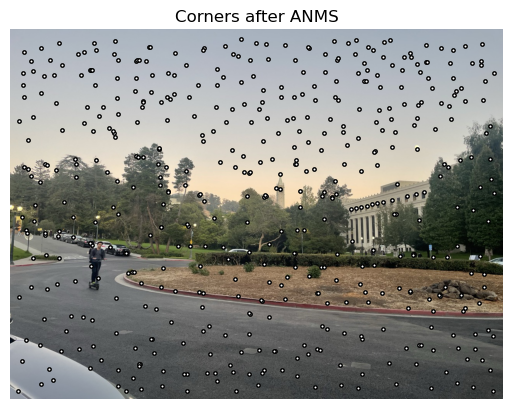

In [5]:
# Visualize the selected corners after ANMS
plt.imshow(image1, cmap='gray')
plt.scatter(suppressed_coords[1], suppressed_coords[0], facecolors='white', edgecolors='black', s=6, linewidths=1)
plt.title('Corners after ANMS')
plt.axis('off')
plt.show()

## Feature Descriptor extraction

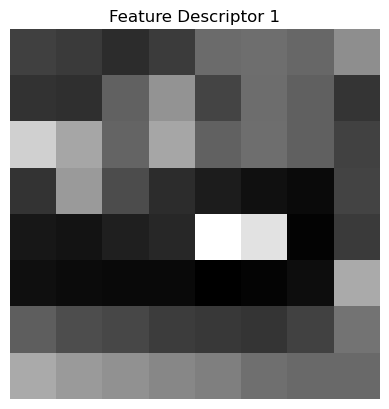

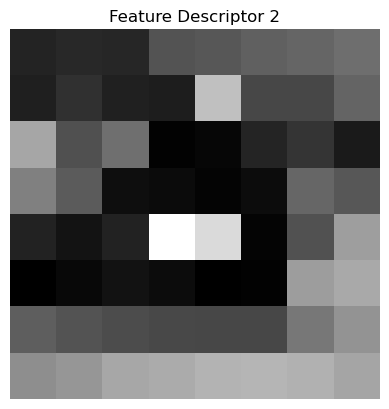

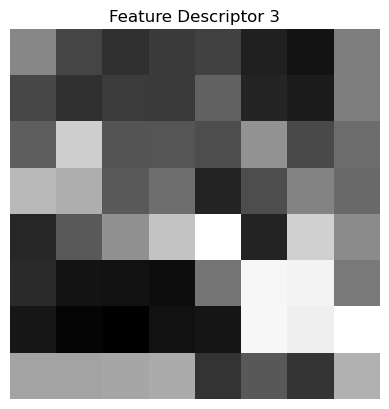

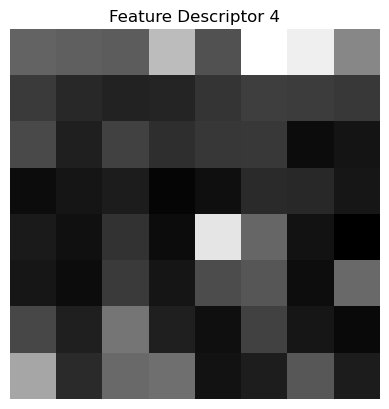

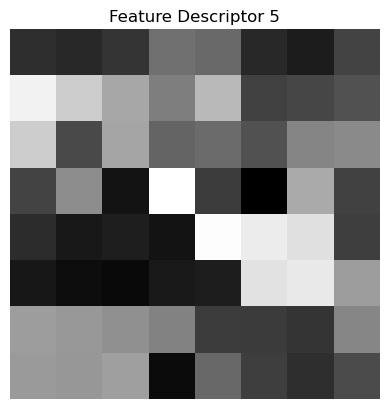

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def extract_patch(im, center, patch_size):
    y, x = center
    half_size = patch_size // 2
    # Ensure indices are within image bounds
    y1, y2 = max(0, y - half_size), min(im.shape[0], y + half_size)
    x1, x2 = max(0, x - half_size), min(im.shape[1], x + half_size)
    return im[y1:y2, x1:x2]

def downsample_patch(patch, spacing=5):
    return patch[::spacing, ::spacing]  # Simple downsampling by skipping rows and columns


def normalize_patch(patch):
    patch_mean = np.mean(patch)
    patch_std = np.std(patch)
    
    if patch_std > 0:
        normalized_patch = (patch - patch_mean) / patch_std
    else:
        normalized_patch = patch - patch_mean  # Prevent division by zero
    return normalized_patch

def extract_feature_descriptors(im, corners, patch_size=40, spacing=5):
    """
    Extracts feature descriptors (8x8 patches) from the image around each corner.
    
    :param im: Input grayscale image.
    :param corners: Array of corner points (2, n) format (ys, xs).
    :param patch_size: Size of the patch to extract around each corner (default = 40).
    :param spacing: The downsampling factor (default = 5).
    :return: Array of 8x8 normalized feature descriptors.
    """
    descriptors = []
    
    for y, x in zip(corners[0], corners[1]):
        # Extract 40x40 patch around the corner
        patch = extract_patch(im, (y, x), patch_size=patch_size)
        
        if patch is None:
            continue  # Skip if the patch is out of bounds
        
        # Downsample the patch to 8x8
        small_patch = downsample_patch(patch, spacing=spacing)
        
        # Normalize the patch (bias/gain normalization)
        normalized_patch = normalize_patch(small_patch)
        
        # Store the normalized patch (feature descriptor)
        descriptors.append(normalized_patch)
    
    return np.array(descriptors)

# Load the grayscale image (as already done earlier)
# Harris corners should already be detected
# Example: image1_gray and corners (as detected Harris points)

# Extract feature descriptors for the detected corners
descriptors = extract_feature_descriptors(image1_gray, suppressed_coords)

# Visualize the first few feature descriptors as 2D matrices
num_to_visualize = 5  # Number of descriptors to visualize
for i in range(num_to_visualize):
    if i < len(descriptors):  # Check to avoid index errors
        plt.imshow(descriptors[i], cmap='gray')
        plt.title(f'Feature Descriptor {i+1}')
        plt.axis('off')
        plt.show()

## Feature Matching